Chapter 2 - Gaussian Bayesian Networks - learning parameters from data

The crop data <br>
G = genetic potential <br>
E = environmental potential <br>
V = vegatative mass <br>
N = number of seeds (@ flowering time) <br>
W = average weight (later in plants life) <br>
C = crop <br>

$G\sim N(50, 10^2)$ <br>
$E \sim N(50, 10^2)$ <br>
$V \mid G = g,E=e \sim N(-10.35 + 0.5g+0.70e, 5^2)$ <br>
$N \mid V = v \sim N(45 + 0.1v, 9.95^2)$<br>
$W \mid V = v \sim N(15 + 0.7v, 7.14^2)$<br>
$C \mid N = n, W = w \sim N(0.3n + 0.7w, 6.25^2)$<br>

In [ ]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(bnlearn)

In [22]:
install.packages(
  "rbmn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(rbmn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [27]:
# From Lab 7 -- the paramaterization
# Specify the BN (from formula --> graph)
dag.bnlearn <- model2network("[G][E][V|G:E][N|V][W|V][C|N:W]")

# Specify the distributions
disE <- list(coef = c("(Intercept)" = 50), sd = 10)
disG <- list(coef = c("(Intercept)" = 50), sd = 10)
disV <- list(coef = c("(Intercept)" = -10.35, E = .70, G = 0.5), sd = 5)
disN <- list(coef = c("(Intercept)" = 45, V = .1), sd = 9.95)
disW <- list(coef = c("(Intercept)" = 15, V = 0.7), sd = 7.14)
disC <- list(coef = c("(Intercept)" = 0, N = 0.3, W = 0.7), sd = 6.25)

# put them together for bn parameterization
dis.list <- list(E = disE, G = disG, V = disV, N = disN, W = disW, C = disC)

gbn.bnlearn <- custom.fit(dag.bnlearn, dist = dis.list)

In [24]:
# convert my bn object over to rbmn (by the book)

In [28]:
class(gbn.bnlearn) # we are currently using bn lib, shift to rbmn

[1] "bn.fit"      "bn.fit.gnet"

In [29]:
gbn.rbmn <- bnfit2nbn(gbn.bnlearn)
gema.rbmn <- nbn2gema(gbn.rbmn)
mn.rbmn <- gema2mn(gema.rbmn)

In [30]:
# We have a BN that is paramaterized -- we should be able to simulate data from the distributions
set.seed(123)
cropdata0 <- rbn(gbn.bnlearn, n = 10) # very small sample size
cropdata1 <- rbn(gbn.bnlearn, n = 100) # moderate size
cropdata2 <- rbn(gbn.bnlearn, n = 500) # larger (but not large)

In [31]:
# Estimate paramaters for the BN network: in this lab we show how size of sample size affects the parameterization
est.para <- bn.fit(dag.bnlearn, data = cropdata1)
est.para


  Bayesian network parameters

  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -0.6732344    0.2644137    0.7301709  
Standard deviation of the residuals: 6.317257 

  Parameters of node E (Gaussian distribution)

Conditional density: E
Coefficients:
(Intercept)  
   50.06247  
Standard deviation of the residuals: 9.514296 

  Parameters of node G (Gaussian distribution)

Conditional density: G
Coefficients:
(Intercept)  
   49.36822  
Standard deviation of the residuals: 9.47712 

  Parameters of node N (Gaussian distribution)

Conditional density: N | V
Coefficients:
(Intercept)            V  
46.53808912   0.06281624  
Standard deviation of the residuals: 10.09673 

  Parameters of node V (Gaussian distribution)

Conditional density: V | E + G
Coefficients:
(Intercept)            E            G  
 -9.2769899    0.7084482    0.4806641  
Standard deviation of the residuals: 5.311925 

  Parameters o

In [32]:
est.para$C


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -0.6732344    0.2644137    0.7301709  
Standard deviation of the residuals: 6.317257 

In [33]:
# compare to the "true paramaterization"
gbn.bnlearn$C


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
        0.0          0.3          0.7  
Standard deviation of the residuals: 6.25 

In [34]:
# An aside -- look at the effect of sample size on the estimation
est.para.small <- bn.fit(dag.bnlearn, data = cropdata0)
est.para.large <- bn.fit(dag.bnlearn, data = cropdata2)

In [35]:
gbn.bnlearn$C
est.para.small$C
est.para$C
est.para.large$C


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
        0.0          0.3          0.7  
Standard deviation of the residuals: 6.25 


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -2.5715080    0.3608379    0.7146310  
Standard deviation of the residuals: 6.052314 


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -0.6732344    0.2644137    0.7301709  
Standard deviation of the residuals: 6.317257 


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -1.7855116    0.3410371    0.6973984  
Standard deviation of the residuals: 6.327551 

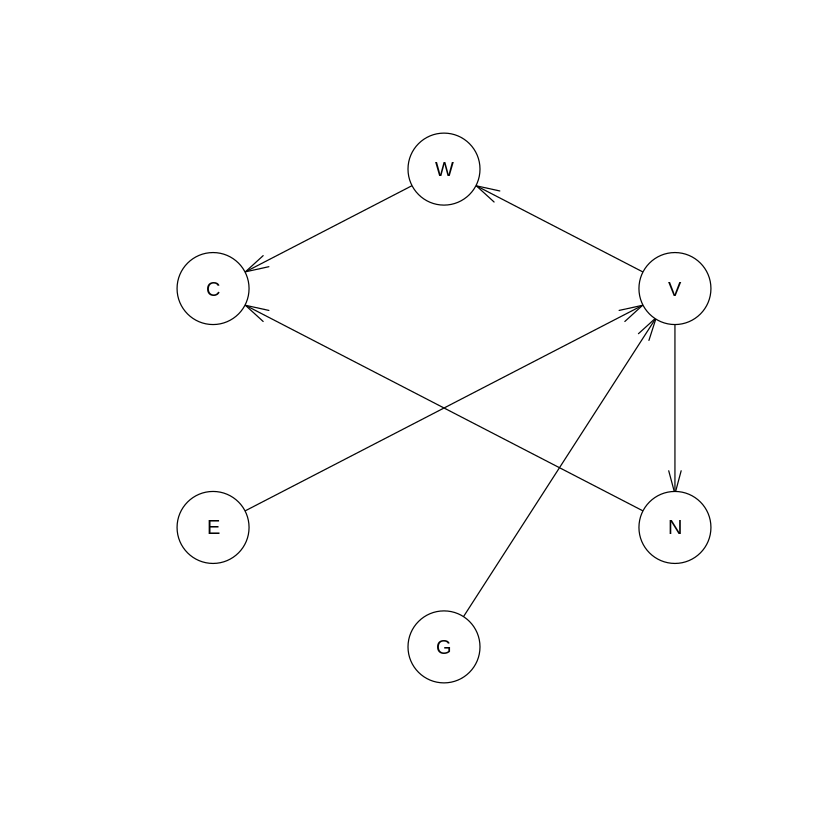

In [36]:
plot(dag.bnlearn)

In [41]:
# use regression to estimate the parameters: here we want to estimate parameters of C using its parents N & W, this is done with regression
lmC <- lm(C ~ N + W, data = cropdata1[,c("N", "W", "C")] ) #book

In [42]:
lmC


Call:
lm(formula = C ~ N + W, data = cropdata1[, c("N", "W", "C")])

Coefficients:
(Intercept)            N            W  
    -0.6732       0.2644       0.7302  


In [43]:
est.para$C # the medium sample size was used and it matches our estimate lmC


  Parameters of node C (Gaussian distribution)

Conditional density: C | N + W
Coefficients:
(Intercept)            N            W  
 -0.6732344    0.2644137    0.7301709  
Standard deviation of the residuals: 6.317257 

In [44]:
# just out of curiosity, lets see if we dont give vector c
lmC2 <- lm(C ~ N + W, data = cropdata1)
lmC2 # its the same so we can choose to drop c as long as we are telling C~N+W


Call:
lm(formula = C ~ N + W, data = cropdata1)

Coefficients:
(Intercept)            N            W  
    -0.6732       0.2644       0.7302  


In [45]:
lmV <- lm(V ~ E + G, data = cropdata1)
lmV


Call:
lm(formula = V ~ E + G, data = cropdata1)

Coefficients:
(Intercept)            E            G  
    -9.2770       0.7084       0.4807  


In [46]:
est.para$V # ours above is similar to below


  Parameters of node V (Gaussian distribution)

Conditional density: V | E + G
Coefficients:
(Intercept)            E            G  
 -9.2769899    0.7084482    0.4806641  
Standard deviation of the residuals: 5.311925 

In [47]:
# grab some of the information from the linear model
lmC <- lm(C ~ N + W, data = cropdata1)
coef(lmC) # we can see we don't get 0 for intercept of C as given by the expert but even below in CI we see that there is a C intercept

(Intercept)           N           W 
 -0.6732344   0.2644137   0.7301709

$C \mid N = n, W = w \sim N(0.3n + 0.7w, 6.25^2)$<br>

In [48]:
confint(lmC) # confidence interval; see intercept

,2.5 %,97.5 %
(Intercept),-9.4996743,8.1532055
N,0.1384064,0.3904210
W,0.5958192,0.8645225


In [50]:
# an alternative layer to estimating C
lm(C ~ N + W - 1, data = cropdata1)


Call:
lm(formula = C ~ N + W - 1, data = cropdata1)

Coefficients:
     N       W  
0.2584  0.7230  


In [ ]:
# now we see N and W are closer to real values & there is no longer the intercept term